1. 1. Elección de datos y breve descripción de su naturaleza (¿de qué tratan?).

- Introducción.

- Objetivos generales: mostrar la potencia de las herramientas de estadística descriptivasy ... a la hora de describir los datos

- Objetivos particulares:Objetivos particulares, aprender, mostrar lo aprendido, etc...

- Dataset elegido:

Nuestro dataset fifa_players.csv obtenido en Kaggle, recoge ~
17,000 entradas de futbolistas (hombres), con 51 características, como nombre, edad, peso, habilidades, puntuación global o posición en el campo, por ejemplo.

Sobre esta muestra de ~17,000 entradas vamos a realizar una caracterización de la distribución de las variables y un análisis de variación (ANOVA) a partir del cual trataremos de inferir conclusiones sobre la población (total de futbolistas hombres en el mundo).

Pasamos en primer lugar a importar las librerrías sin las cuales no podemos continuar con nuestro análisis:

In [1]:
!pip install distfit
!pip install pycountry_convert

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
import math
from distfit import distfit
from itertools import combinations
import pycountry_convert as pc
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

2. Descriptiva univariante y bivariante de los datos teniendo en cuenta su tipo.

Explicamos si cabe e importamos el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
fifa_all = pd.read_csv('/content/drive/MyDrive/fifa_players.csv')


In [3]:
# Para trabajar en local:

fifa_all=pd.read_csv('C:\\Users\\josan\\Documents\\GitHub\\EDEM_MDA2324\\Alumnos\\ES\\Josan_Rodrigo_Cortes\\Estadística\\trabajodefinitivo\\fifa_players.csv')

2.1. Tipos de variables

Usamos el metodo head de pandas para mostrar el contenido de las tres primeras filas del datset. Podemos ver que está compueto por :

In [4]:
fifa_all.head(3)

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67


In [5]:
fifa_all.columns
# ESTO IGUAL LO DEBERÍAMOS QUITAR

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')

Breve descripción o diagrama de pastel para ver cuantas variables son cuantitativas y cuantas cualitativas:

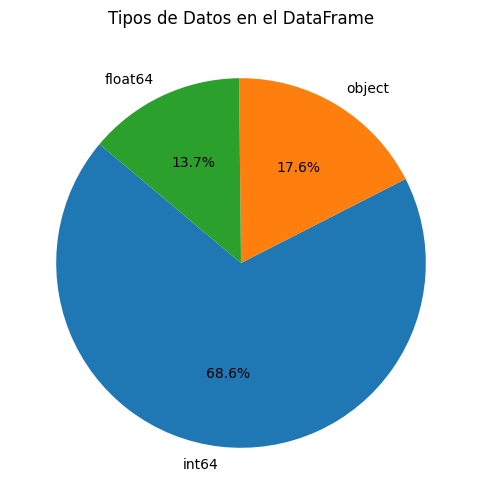

In [6]:
# Crear un DataFrame que contenga los tipos de datos de cada columna
data_types = pd.DataFrame(fifa_all.dtypes, columns=['Tipo de Datos'])

# Contar el número de variables de cada tipo de datos
data_type_counts = data_types['Tipo de Datos'].value_counts()

# Crear el diagrama de pastel
plt.figure(figsize=(8, 6))
data_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Tipos de Datos en el DataFrame')
plt.ylabel('')  # Eliminar la etiqueta del eje y
plt.show()

Vamos a elegir las variables de nuestro análisis

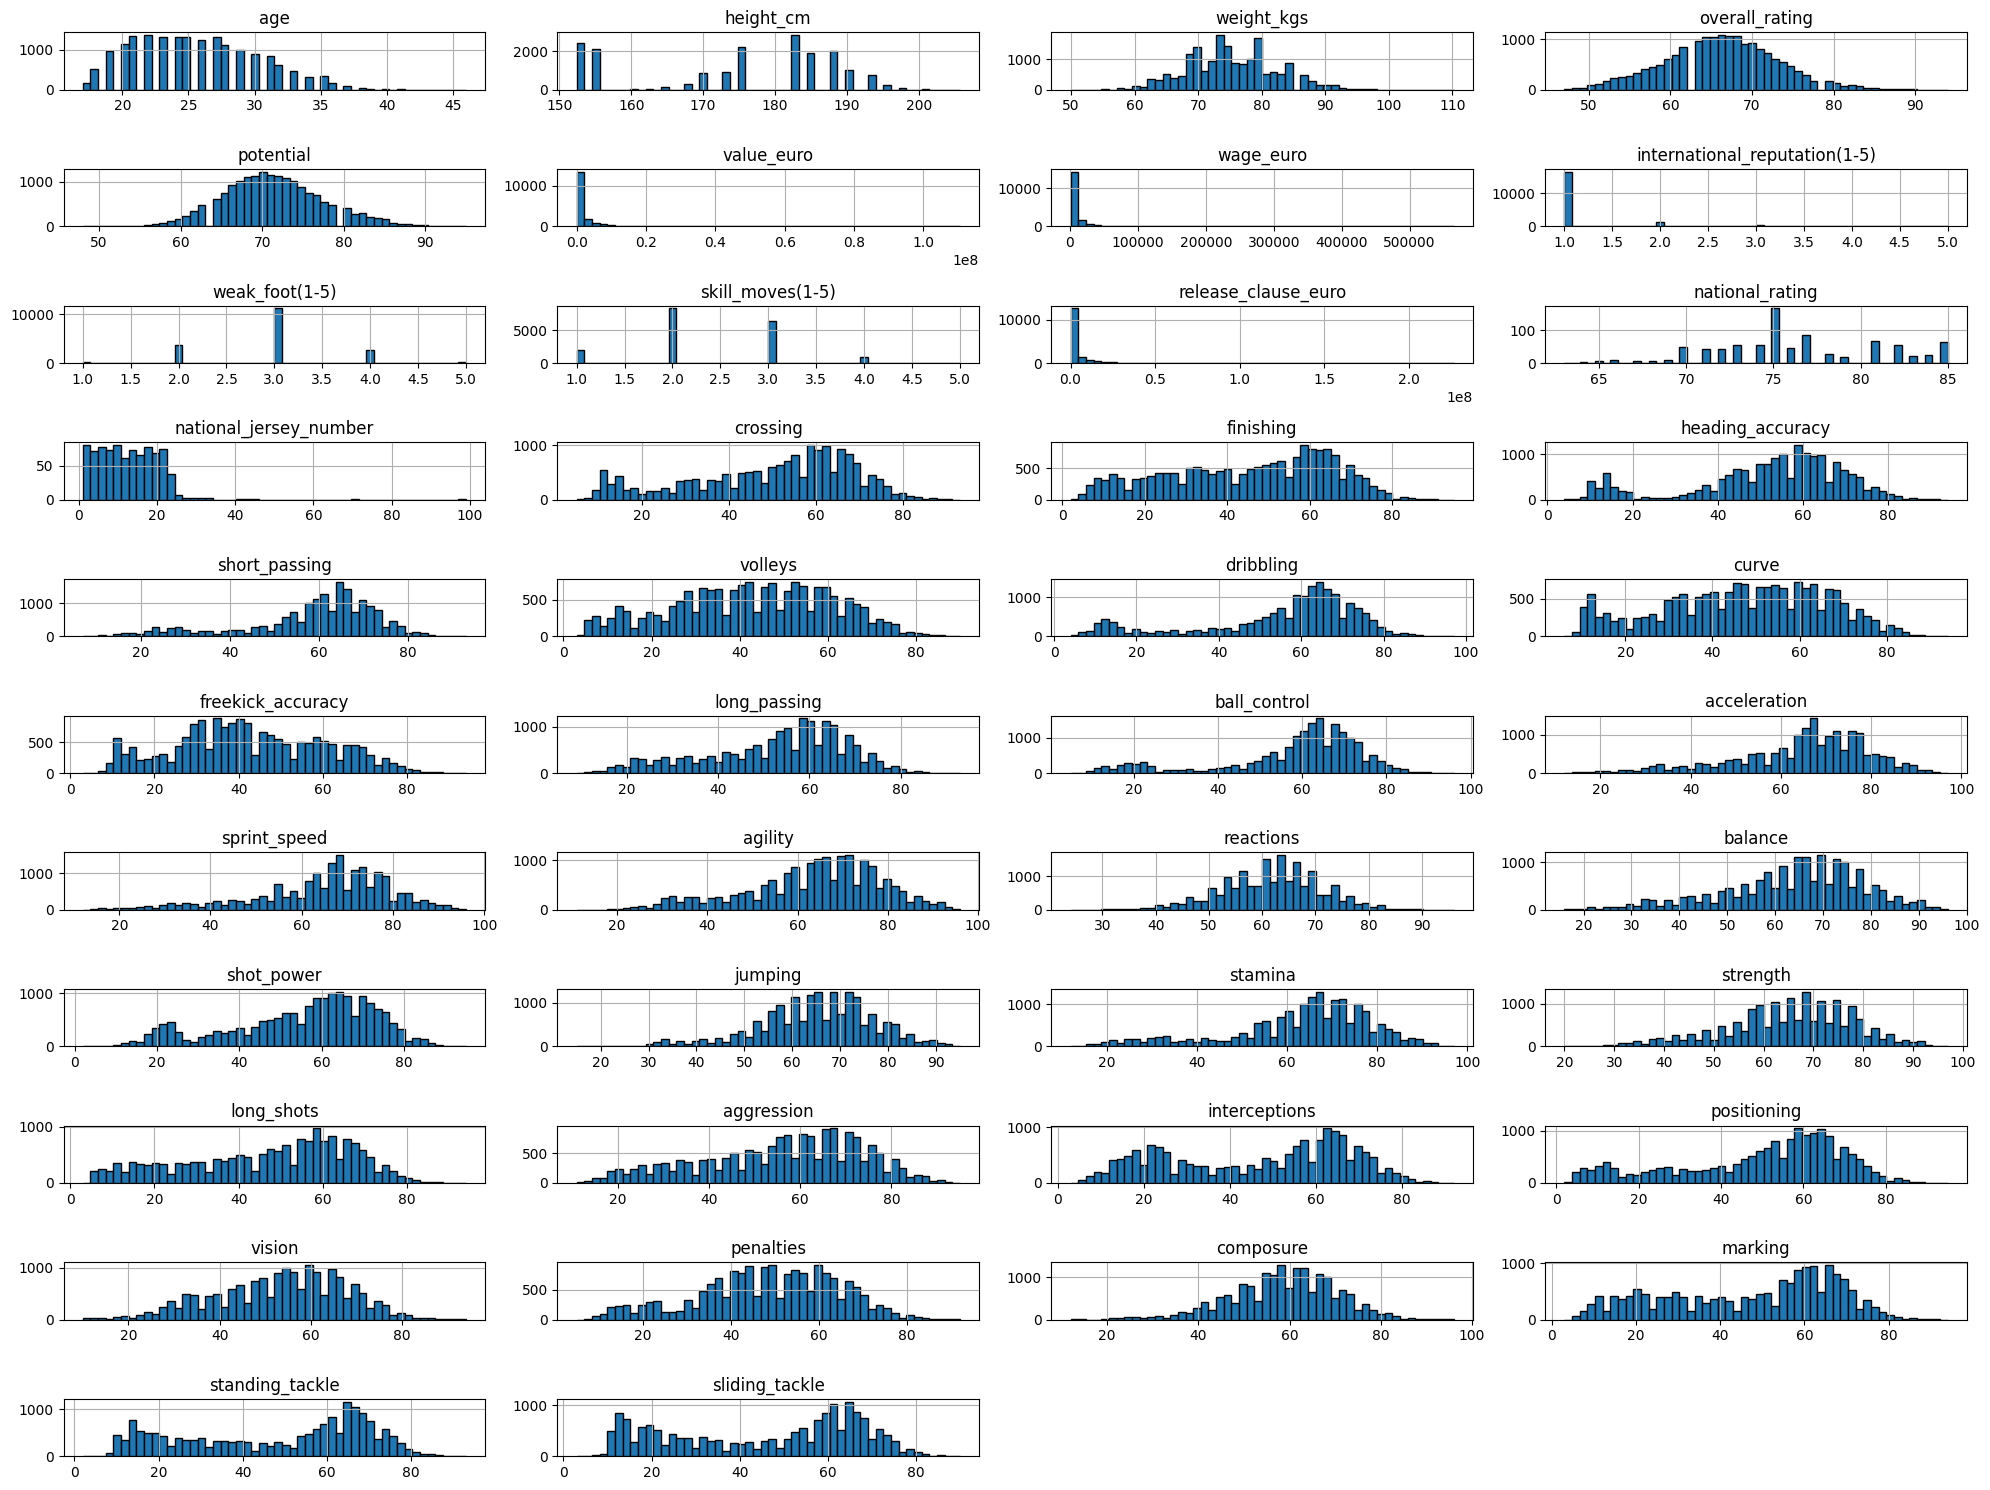

In [7]:
columns = fifa_all.columns

fifa_all.hist(figsize=(20, 15), bins=50, layout=(-1, 4), edgecolor='black')
plt.tight_layout()
plt.show()

En la imagen anterior podemos ver un histograma de todas las variables presentes en nuestros datos, por su aparente normalidad pasaremos ahoara a centrar nuestro análisis en:

- Overal_rating
- Potential

Por otro lado, decidimos tomar nacionalidad y posición como variables categóricas, ya parecen dos variables interesantes sobre las que poder inferir luego en la población:


In [8]:
frequency_of_nationalities = fifa_all['nationality'].value_counts()
frequency_of_nationalities

England                 1658
Germany                 1199
Spain                   1070
France                   925
Argentina                904
                        ... 
Papua New Guinea           1
South Sudan                1
Malta                      1
Yemen                      1
United Arab Emirates       1
Name: nationality, Length: 160, dtype: int64

In [9]:
frequency_of_positions = fifa_all['positions'].value_counts()
frequency_of_positions


CB              2243
GK              2065
ST              1747
CM               764
CDM,CM           709
                ... 
LB,LM,CB           1
CF,CM,ST           1
CB,ST              1
RB,ST              1
CAM,CM,RW,RM       1
Name: positions, Length: 890, dtype: int64

Tras revisar la dispersión de las dos variables categoricas decidimos, agrupar los nacionalidades por continentes y tomar la primera posición del listado de posiciones de cada jugador como la posición dominante del mismo para simplificar nuestro analisis. Tambien decidimos traducir el nombre de la posición para mayor claridad en conclusiones posteriores. + Eliminar los valores nulos

In [10]:
# Group by positions
# Note: Since players can have multiple positions, here we consider just their primary position.
fifa_all['primary_position'] = fifa_all['positions'].apply(lambda x: x.split(',')[0])

# Renaming entries in column 'primary_position'
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'GK': 'PORTERO'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CAM': 'MEDIO OF'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CM': 'CENTROCAM.'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'LW': 'EXT IZQ'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'RW': 'EXT DER'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CB': 'DEF CENT'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'ST': 'ATAC'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CF': 'DEL CENT'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'CDM': 'CENT DEF'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'LB': 'LAT IZQ'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'RB': 'LAT DER'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'LM': 'CENT IZQ'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'RM': 'CENT DER'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'LWB': 'INT IZQ'})
fifa_all['primary_position'] = fifa_all['primary_position'].replace({'RWB': 'INT DER'})

# Definir una función para obtener el continente de un país
def get_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

# Aplicar la función a la columna 'nationality' para obtener el continente correspondiente
fifa_all['continent'] = fifa_all['nationality'].apply(get_continent)

# Ahora, fifa_all contiene una nueva columna 'continent' que indica el continente al que pertenece cada país

fifa_all = fifa_all.dropna(subset=['continent'])
fifa_all.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,primary_position,continent
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,22,94,94,75,96,33,28,26,DEL CENT,South America
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,56,84,91,67,88,59,57,22,MEDIO OF,Europe
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,64,82,88,82,87,63,67,67,CENTROCAM.,Europe
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,26,83,87,61,83,51,24,22,EXT IZQ,Europe
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,88,24,49,33,80,91,88,87,DEF CENT,Africa


2.2 Medidas descriptivas univariantes, de posición y dispersión

In [11]:
columns_to_analize=['overall_rating','potential']
fifa_all[columns_to_analize].describe()

,overall_rating,potential
count,14496.000000,14496.000000
mean,66.955160,72.011038
std,6.849744,5.949449
min,47.000000,50.000000
25%,63.000000,68.000000
50%,67.000000,72.000000
75%,71.000000,76.000000
max,94.000000,95.000000


Aqui faltaria un histograma + density de las dos continuas y otros dos de las dos variables

Seria muy chulo superponer una normal y una t student para continuar el análisis

Hablar de la normalidad de las dos variables

Metemos el boxplot o bigotes aquí?



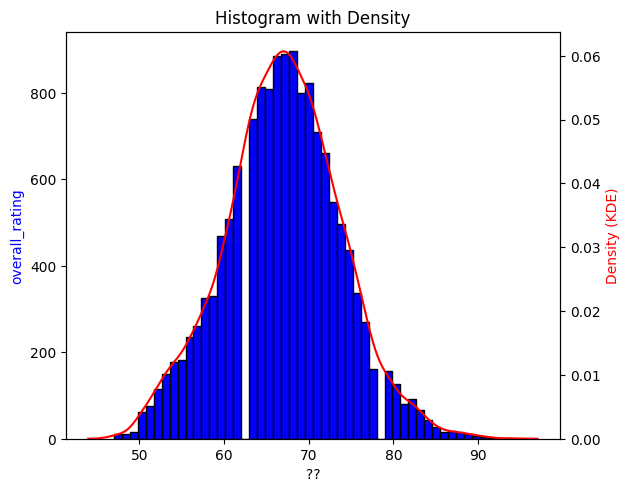

In [16]:
# Primera variable

# Crear figura y ejes
fig, ax = plt.subplots()

# Generar histograma en el primer eje
ax.hist(fifa_all['overall_rating'], bins=50, edgecolor='black', color='blue')
ax.set_xlabel('??')
ax.set_ylabel('overall_rating', color='blue')

# Crear un segundo eje y duplicar el primero
ax2 = ax.twinx()

# Agregar la función de densidad (KDE) en el segundo eje
sns.kdeplot(fifa_all['overall_rating'], color='red', ax=ax2)
ax2.set_ylabel('Density (KDE)', color='red')

# Mostrar gráfico
plt.tight_layout()
plt.title('Histogram with Density')
plt.show()



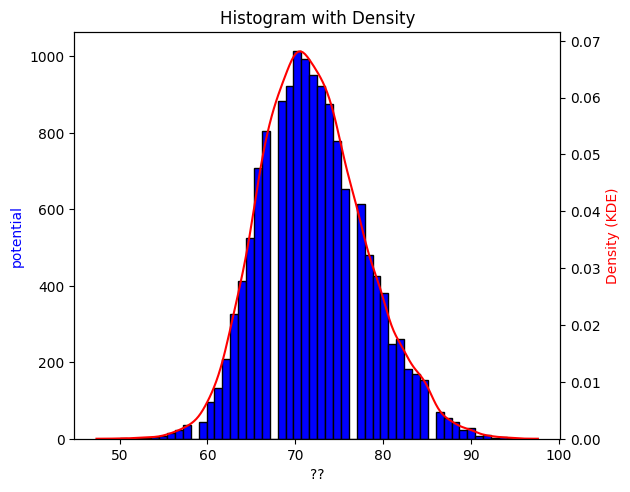

In [19]:
# Segunda variable Potential


# Crear figura y ejes
figb, ax = plt.subplots()

# Generar histograma en el primer eje
ax.hist(fifa_all['potential'], bins=50, edgecolor='black', color='blue')
ax.set_xlabel('??')
ax.set_ylabel('potential', color='blue')

# Crear un segundo eje y duplicar el primero
ax2 = ax.twinx()

# Agregar la función de densidad (KDE) en el segundo eje
sns.kdeplot(fifa_all['potential'], color='red', ax=ax2)
ax2.set_ylabel('Density (KDE)', color='red')

# Mostrar gráfico
plt.tight_layout()
plt.title('Histogram with Density')
plt.show()

2.2 Medidas descriptivas bivariantes: covarianza y coeficiente de Pearson

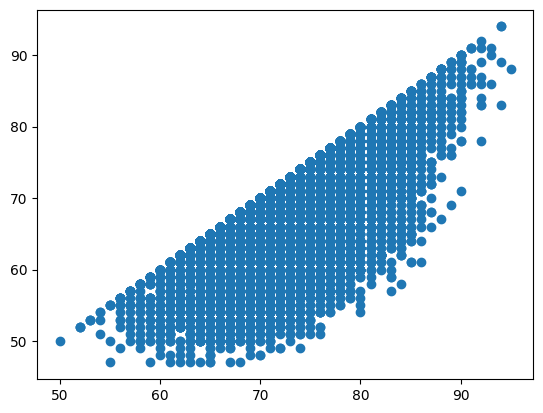

In [21]:
from numpy.lib.function_base import corrcoef


plt.scatter(fifa_all['potential'],fifa_all['overall_rating']
)

plt.show()

Vemos una correlación bastante fuerte entre las dos variables, vamos a proceder a calcular su coef de correlación


In [23]:
corrcoef(fifa_all['potential'],fifa_all['overall_rating'])

array([[1.       , 0.6456477],
       [0.6456477, 1.       ]])

In [29]:
correlation_matrix = fifa_all[['potential','overall_rating','continent','primary_position']].corr(method='spearman')
# Esto nos devuelve lo mismo que el anterior, y no podemo calcular ninguna correlación revisar lo siguiente:

correlation_matrix

,potential,overall_rating
potential,1.000000,0.610264
overall_rating,0.610264,1.000000


Si tus variables categóricas pueden tomar más de dos valores, entonces necesitarás considerar una técnica diferente para calcular la correlación entre ellas. Una opción sería utilizar el coeficiente de contingencia (también conocido como coeficiente de asociación de Pearson para variables categóricas), que es una medida de asociación entre dos variables categóricas.

Puedes calcular el coeficiente de contingencia utilizando la función contingency_matrix de la biblioteca scipy.stats. Aquí te muestro un ejemplo de cómo hacerlo:

python
Copy code
from scipy.stats import chi2_contingency

# Suponiendo que 'variable1' y 'variable2' son tus variables categóricas
contingency_table = pd.crosstab(fifa_all['variable1'], fifa_all['variable2'])

# Calcula el coeficiente de contingencia
chi2, _, _, _ = chi2_contingency(contingency_table)

# Calcula el coeficiente de correlación de Pearson a partir del chi-cuadrado
n = contingency_table.sum().sum()
pearson_corr = np.sqrt(chi2 / (n + chi2))

print("Coeficiente de correlación de contingencia:", pearson_corr)
Este código calculará el coeficiente de contingencia entre las variables categóricas 'variable1' y 'variable2'. El coeficiente de contingencia oscila entre 0 y 1, donde 0 indica independencia y 1 indica una asociación completa entre las variables categóricas.








- Otros: tablas de frecuencias relativas y absolutas, graficos de barras e histogramas, density, boxplot, describe, whisker, coef. correlación, matriz de correlación, no sé si puede valer la pena descomponer alguna variable en nuestro caso.

3. Comprobación de la normalidad de alguna/s variable/s del conjunto de datos.



Ahora, mediante la librería distfit analizamos qué distribucuón se ajustaría mejor a 'overall_rating' y 'potential':

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.034634] [loc=66.955 scale=6.850]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0767882] [loc=47.000 scale=19.955]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 0.0767882] [loc=-4294967249.000 scale=4294967296.000]
[distfit] >INFO> [dweibull  ] [0.12 sec] [RSS: 0.0365272] [loc=66.558 scale=5.831]
[distfit] >INFO> [t         ] [1.51 sec] [RSS: 0.0345666] [loc=66.952 scale=6.700]
[distfit] >INFO> [genextreme] [0.56 sec] [RSS: 0.0353982] [loc=64.332 scale=6.780]
[distfit] >INFO> [gamma     ] [0.36 sec] [RSS: 0.0346764] [loc=-323.808 scale=0.120]
[distfit] >INFO> [lognorm   ] [0.01 sec] [RSS: 0.034675] [loc=-532.976 scale=599.892]
[distfit] >INFO> [beta      ] [0.59 sec] [RSS: 0.0347021] [loc=-191.726 scale=857862.661]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0660605] [loc=47.000 scale=47.000]
[distfit] >INFO> [loggamma  ] [0.14 sec] [RSS: 0.0346148] [loc=-1340.990 scale=206.809]
[di

          name     score           loc          scale  \
0            t  0.034567     66.951764       6.700384   
1     loggamma  0.034615  -1340.989679     206.808831   
2         norm  0.034634      66.95516       6.849508   
3      lognorm  0.034675   -532.976158     599.892221   
4        gamma  0.034676   -323.808283       0.120062   
5         beta  0.034702   -191.725924  857862.660551   
6   genextreme  0.035398     64.331863       6.779752   
7     dweibull  0.036527     66.558092       5.831256   
8      uniform  0.066061          47.0           47.0   
9       pareto  0.076788 -4294967249.0   4294967296.0   
10       expon  0.076788          47.0       19.95516   

                                        arg  \
0                       (46.2785791710783,)   
1                       (905.486319525809,)   
2                                        ()   
3                   (0.011416715628033852,)   
4                      (3254.664230223365,)   
5   (1424.9130353440576, 4723996.

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nt(df=46.2786, loc=66.9518, scale=6.70038)'}, xlabel='Values', ylabel='Frequency'>)

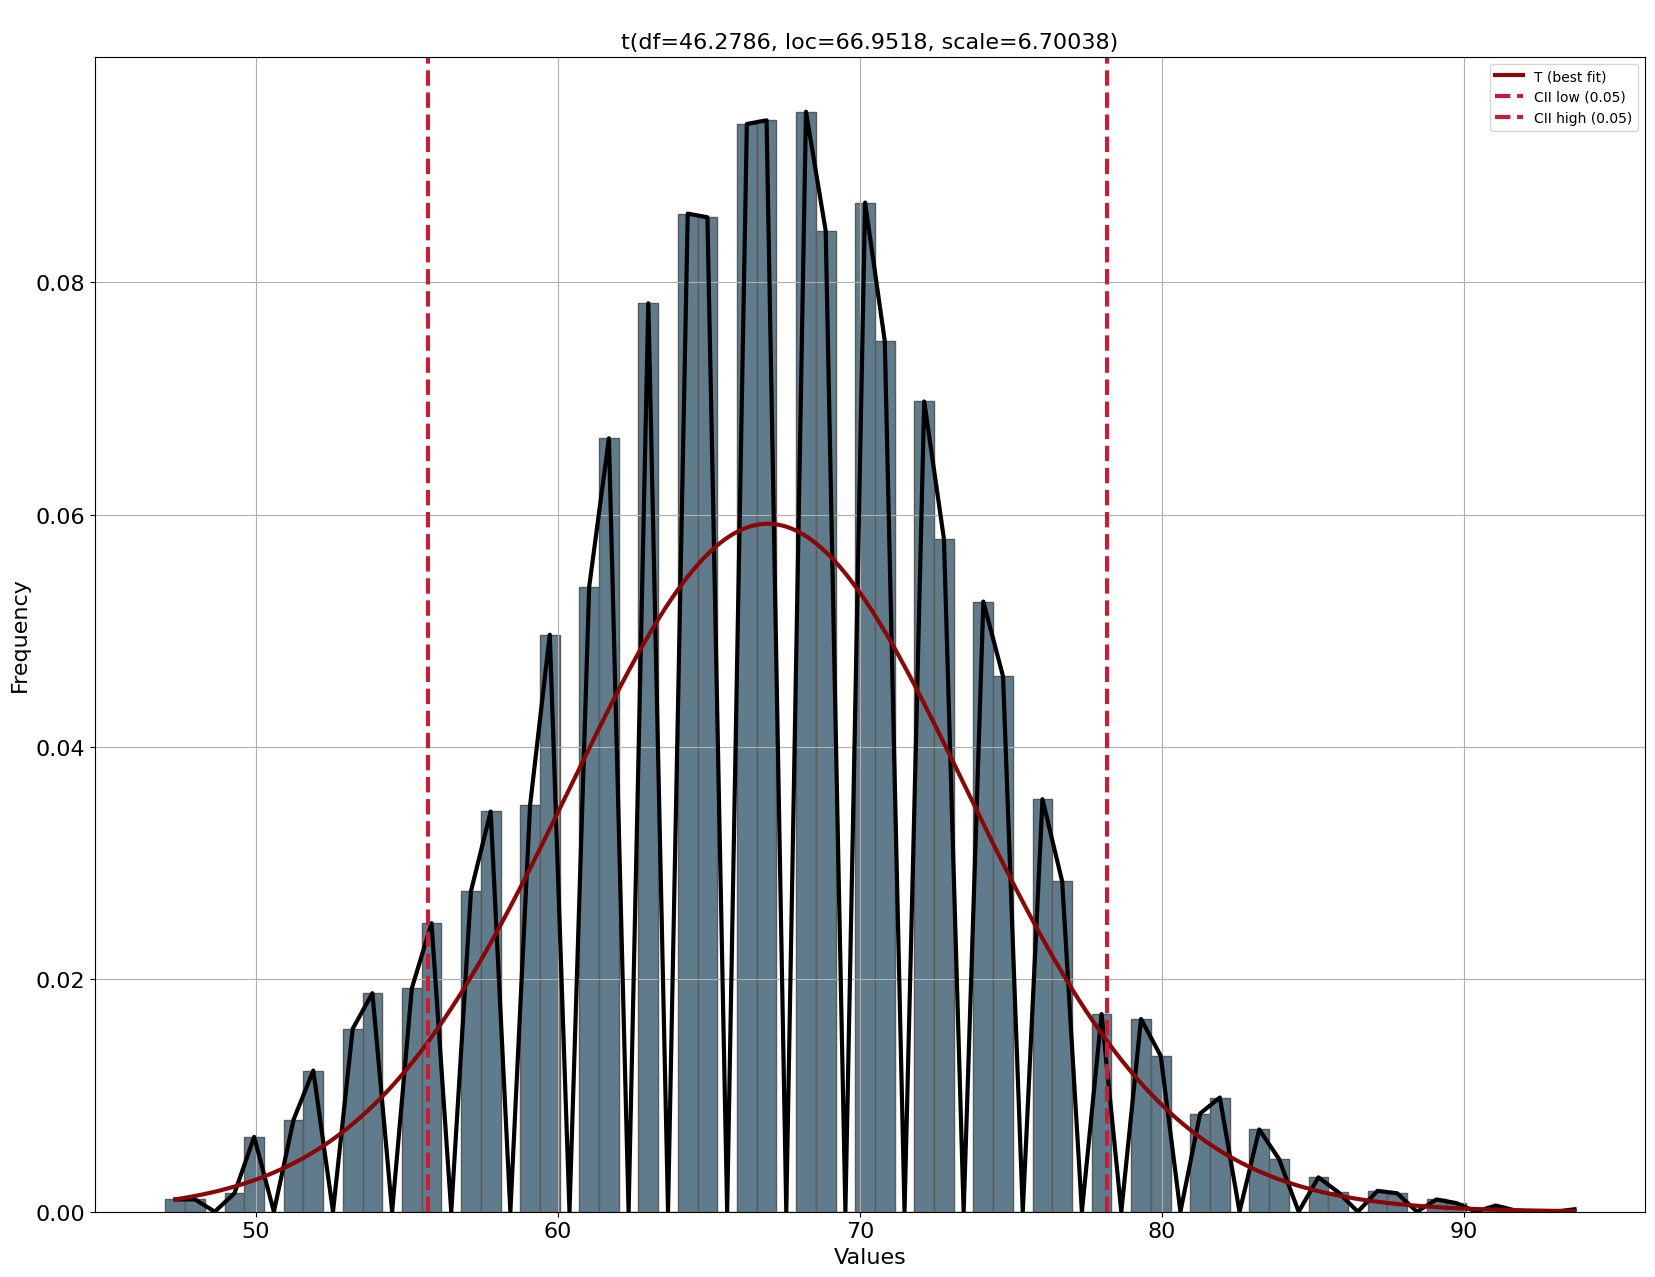

In [30]:
# Initialize distfit
dist = distfit()

# Fit the distribution to your data
dist.fit_transform(fifa_all["overall_rating"])

# Print the summary of the best fit distribution
print(dist.summary)

# Optionally, you can also plot the best fit distribution against your data
dist.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0396767] [loc=72.011 scale=5.949]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.094536] [loc=50.000 scale=22.011]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 0.094536] [loc=-4294967246.000 scale=4294967296.000]
[distfit] >INFO> [dweibull  ] [0.14 sec] [RSS: 0.0412437] [loc=71.556 scale=5.122]
[distfit] >INFO> [t         ] [1.39 sec] [RSS: 0.0396212] [loc=71.989 scale=5.876]
[distfit] >INFO> [genextreme] [0.77 sec] [RSS: 0.038989] [loc=69.673 scale=5.622]
[distfit] >INFO> [gamma     ] [0.11 sec] [RSS: 0.0389687] [loc=32.645 scale=0.898]
[distfit] >INFO> [lognorm   ] [0.01 sec] [RSS: 0.0389467] [loc=15.163 scale=56.540]
[distfit] >INFO> [beta      ] [0.60 sec] [RSS: 0.0389795] [loc=34.839 scale=533.514]
[distfit] >INFO> [uniform   ] [0.0 sec] [RSS: 0.0792524] [loc=50.000 scale=45.000]
[distfit] >INFO> [loggamma  ] [0.19 sec] [RSS: 0.0398063] [loc=-1688.489 scale=238.960]
[distfit] >INFO

          name     score           loc         scale  \
0      lognorm  0.038947     15.162712     56.539606   
1        gamma  0.038969     32.645281      0.898122   
2         beta   0.03898     34.839015    533.513505   
3   genextreme  0.038989     69.673379       5.62243   
4            t  0.039621     71.988983      5.876116   
5         norm  0.039677     72.011038      5.949244   
6     loggamma  0.039806  -1688.489182    238.959605   
7     dweibull  0.041244     71.555988       5.12178   
8      uniform  0.079252          50.0          45.0   
9       pareto  0.094536 -4294967246.0  4294967296.0   
10       expon  0.094536          50.0     22.011038   

                                        arg  \
0                    (0.10435444637460911,)   
1                      (43.83118967823402,)   
2   (36.32505434751738, 485.01545870933137)   
3                    (0.18823730277704265,)   
4                      (81.78550501050199,)   
5                                        ()  

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nlognorm(s=0.104354, loc=15.1627, scale=56.5396)'}, xlabel='Values', ylabel='Frequency'>)

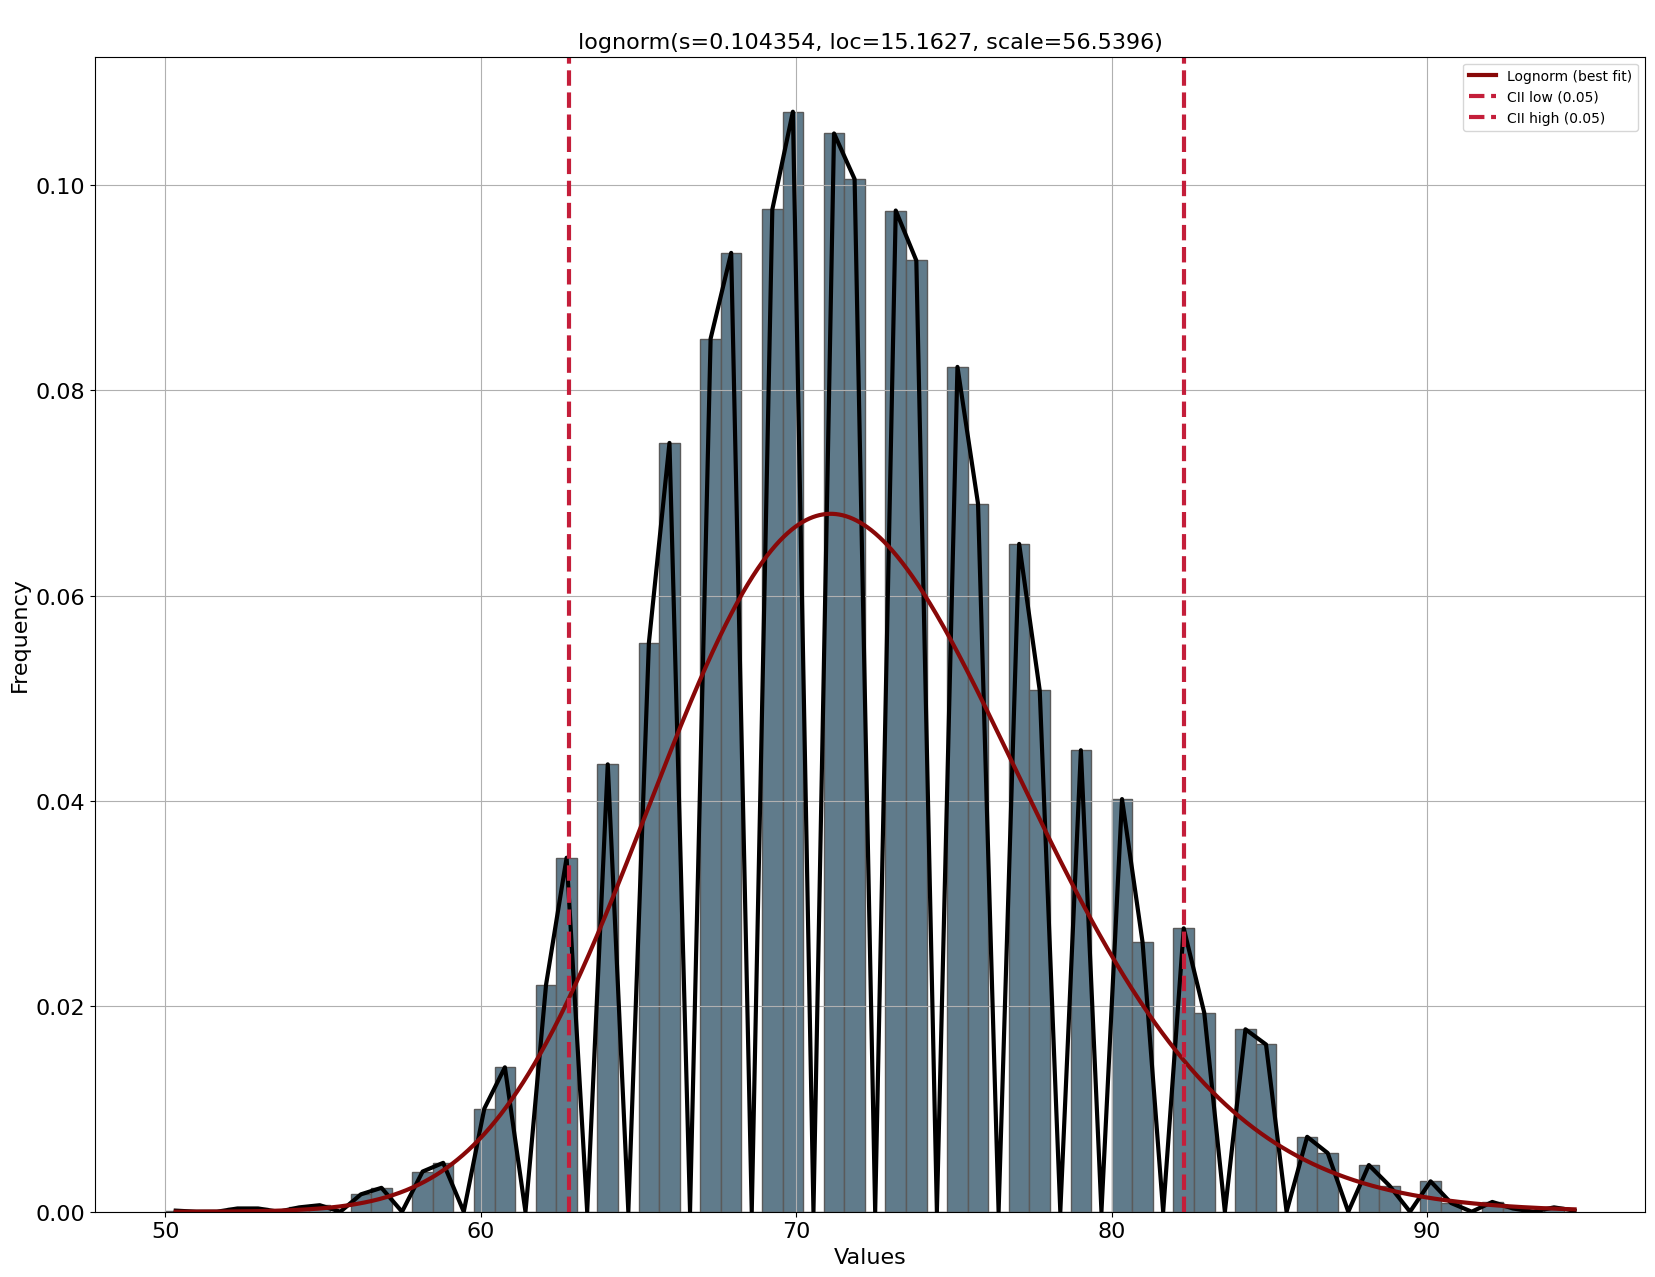

In [31]:
# Initialize distfit
dist = distfit()

# Fit the distribution to your data
dist.fit_transform(fifa_all["potential"])

# Print the summary of the best fit distribution
print(dist.summary)

# Optionally, you can also plot the best fit distribution against your data
dist.plot()


Sí, es posible transformar una variable que sigue una distribución t de Student para que se aproxime a una distribución normal. Esto se puede lograr utilizando la transformación de Box-Cox o la transformación de Yeo-Johnson.

La transformación de Box-Cox es adecuada para variables que son estrictamente positivas, mientras que la transformación de Yeo-Johnson puede manejar variables que contienen valores negativos.

Puedes aplicar estas transformaciones utilizando la función correspondiente de la biblioteca scipy.stats. Aquí tienes un ejemplo de cómo hacerlo:

python
Copy code
from scipy.stats import boxcox

# Suponiendo que 'variable_t_student' es la variable que sigue una distribución t de Student
transformed_variable, lambda_value = boxcox(df['variable_t_student'])

# La variable 'transformed_variable' ahora sigue una distribución normal
Esta transformación ajustará automáticamente la variable para que se aproxime a una distribución normal. Sin embargo, es importante tener en cuenta que estas transformaciones pueden no ser adecuadas en todos los casos, especialmente si los datos no cumplen con las suposiciones subyacentes de las distribuciones. Por lo tanto, siempre es recomendable realizar pruebas y validaciones adicionales después de realizar la transformación.

4. Estimación puntual y por intervalos de los parámetros poblacionales de
algunas variables.

- En este punto necesitaremos decidir si nuestros datos son una muestra para hacer inferencia sobre la población o la población.

- Intervalos de confianza en la estimación de parametros. Z=sigma/raiz2n

- Creacion de intervalos de confianza tanto con la normal como con la t


5. Realización de contrastes de hipótesis oportunos para realizar inferencia con
los datos
- Normalidad de las muestras o población

- Media

- Varianza


6. Realización de ANOVA (cond. de aplicabilidad, ANOVA, post-hoc) para
obtener conclusiones de los datos

- Ya tenemos la anova de ayer y esta genial, ver otras posibilidades.

- Analisis de homocedasticidad y justificación.

- Justificación del uso de la ANOVA

7. Cosas que podríamos añadir y que he visto en los apuntes:

- Potencia de lo test utilizados

- Representación de los errores tipo I y II

- Muestras pareadas.

- Plot de las diferentes muestras y sus intérvalos de confianza.

- Revisar exponencial

- Pensar en si podemos convertir alguna variable en una binomial.

- Investigar cualquier otra via, posibilidad de extrapolar a una posible población más grande los resultados de nuestra población.



tips:
Sumario a la izquierda
Objetivos: generales y especificos
Materiales dataset, metodología, todos las pruebas que se van a realizar y el objetivo de ellas
Resultados, analisis y librerias
Definición de variables: clining del dataset
descriptiva variante y bivariante una de cada tipo de variable
Comentar relaciones causa efecto pero no categorizando los datos
Explicar los gráficos
Diferentes tipos de gráficos
Comentar los resultados de cada ejecución
Estudio de normalidad: hombres, mujeres y todos
Contrastes de hipotesis
Inferencia estadistica, puntual y por intervalos
Contrastes de hipotesis
Anova, condiciones de aplicabilidad, etc..
Conclusiones, lo más importante